In [25]:
import pandas as pd
import numpy as np
#import os
import matplotlib.pyplot as plt
#import scipy.stats as stats
#from collections import defaultdict

#import sklearn as sklearn
#from scipy.stats.stats import pearsonr
#import csv
import seaborn as sns
#import plotly.express as px
#scaling, normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

In [26]:
users = pd.read_csv('users.csv', header=None, on_bad_lines='skip', nrows=1000)
users.columns = ['id', 'login', 'company', 'created_at', 'type', 'fake', 'deleted', 'long', 'lat', 'country_code', 'state', 'city', 'location']
print('users dimension', users.shape)

users dimension (1000, 13)


In [27]:
cols_prepro = users[['company', 'long', 'lat', 'country_code', 'state', 'city', 'location']]

In [28]:
# DEAL WITH MISSING VALUES AND \\N
users['long'] = pd.to_numeric(users['long'], errors="coerce")
users['lat'] = pd.to_numeric(users['lat'], errors="coerce")
users['id'] = pd.to_numeric(users['id'], errors="coerce")
for col in cols_prepro:
    users[col] = users[col].replace('\\N', '', regex=False)
    users[col] = users[col].replace(r'^\s*$', np.nan, regex=True)



In [29]:
users.head()

id          login       company           created_at type  fake  deleted  \
0  -1        0xnoone           NaN  2016-04-18 11:42:46  USR     0        1   
1   1          tosch     Sage GmbH  2008-12-15 12:28:33  USR     0        0   
2   2      jmettraux           NaN  2008-03-22 00:37:42  USR     0        0   
3   3       SMGNMSKD           NaN  2012-08-03 16:08:15  USR     1        1   
4   4  kennethkalmer  @ValuationUp  2008-04-28 17:25:53  USR     0        0   

         long        lat country_code  \
0         NaN        NaN          NaN   
1    0.000000   0.000000          NaN   
2  132.455293  34.385203           jp   
3         NaN        NaN          NaN   
4   28.047305 -26.204103           za   

                                            state          city  \
0                                             NaN           NaN   
1                                             NaN           NaN   
2                            Hiroshima Prefecture     Hiroshima   
3                                             NaN           NaN   
4  City of Johannesburg Metropolitan Municipality  Johannesburg   

                     location  
0                         NaN  
1            Rastede, Germany  
2                   Hiroshima  
3                         NaN  
4  Johannesburg, South Africa

In [30]:
# CONVERT EACH COLUMN IN 0 AND 1
users['type'] = np.where(users['type'] != 'USR', '1', '0')
for col in cols_prepro:
    users[col] = np.where(users[col].isnull(), '0', '1')






In [31]:
users.head()

id          login company           created_at type  fake  deleted long  \
0  -1        0xnoone       0  2016-04-18 11:42:46    0     0        1    0   
1   1          tosch       1  2008-12-15 12:28:33    0     0        0    1   
2   2      jmettraux       0  2008-03-22 00:37:42    0     0        0    1   
3   3       SMGNMSKD       0  2012-08-03 16:08:15    0     1        1    0   
4   4  kennethkalmer       1  2008-04-28 17:25:53    0     0        0    1   

  lat country_code state city location  
0   0            0     0    0        0  
1   1            0     0    0        1  
2   1            1     1    1        1  
3   0            0     0    0        0  
4   1            1     1    1        1

In [33]:
users.dtypes

id               int64
login           object
company         object
created_at      object
type            object
fake             int64
deleted          int64
long            object
lat             object
country_code    object
state           object
city            object
location        object
dtype: object

In [17]:
for col in cols_prepro:
    print(col, users[col].value_counts())



company 0    624
1    376
Name: company, dtype: int64
long 1    910
0     90
Name: long, dtype: int64
lat 1    910
0     90
Name: lat, dtype: int64
country_code 1    506
0    494
Name: country_code, dtype: int64
state 0    560
1    440
Name: state, dtype: int64
city 0    578
1    422
Name: city, dtype: int64
location 1    625
0    375
Name: location, dtype: int64


In [35]:
for col in cols_prepro:
    users[col] = pd.to_numeric(users[col], errors='coerce', downcast='integer')


In [36]:
users.dtypes

id               int64
login           object
company           int8
created_at      object
type            object
fake             int64
deleted          int64
long              int8
lat               int8
country_code      int8
state             int8
city              int8
location          int8
dtype: object

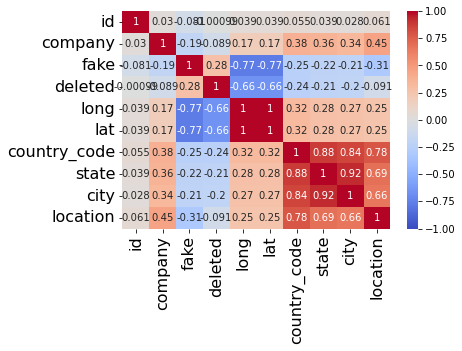

In [37]:
plt.figure()
sns.heatmap(users.corr(method='pearson'), cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [42]:
# SET DATA FOR CLUSTERING
users_clust = users[['company', 'long', 'city']]
cols = [col for col in users_clust.columns]
X = users_clust[cols].values



In [43]:
users_clust.dtypes

company    int8
long       int8
city       int8
dtype: object

In [46]:
type(X)

numpy.ndarray

In [44]:
scaler = MinMaxScaler() 
X_minmax = scaler.fit_transform(X)




In [52]:
wcss = [] 
for i in range(1, 6): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

C:\Users\costa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


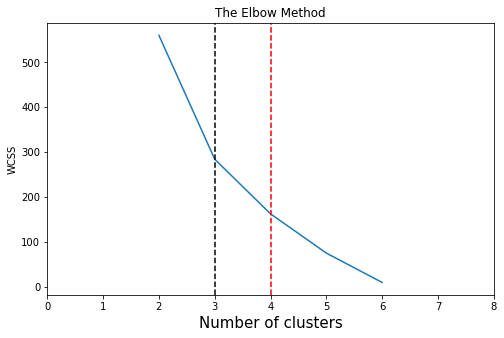

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(wcss)+2), wcss)  # , xticks=range(6)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('WCSS')
plt.axvline(x=3, color='k', linestyle='--')
plt.axvline(x=4, color='r', linestyle='--')
plt.xlim([0, 8])
plt.show()


In [55]:
kmeans = KMeans(n_clusters = 3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit(X)


In [56]:
centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers)

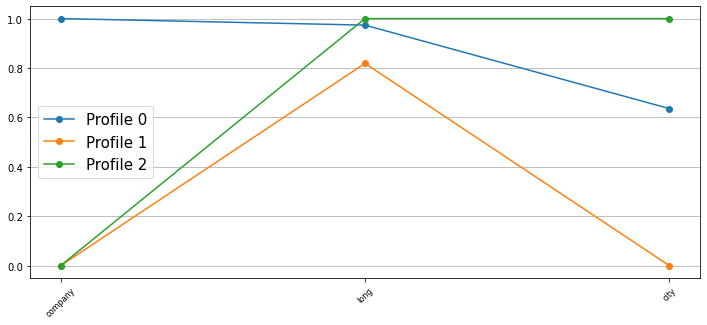

In [57]:
# PLOT THE GRAPH
users['kmeans_labels'] = kmeans.labels_

# CENTERS DISTINCTION
plt.figure(figsize=(12, 5))
clust_name = ['Profile 0', 'Profile 1', 'Profile 2']
for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])

plt.xticks(range(0, len(cols)), cols, fontsize=8, rotation=45)
plt.yticks(fontsize=10)

plt.legend(fontsize=15, loc='best')
plt.grid(axis='y')

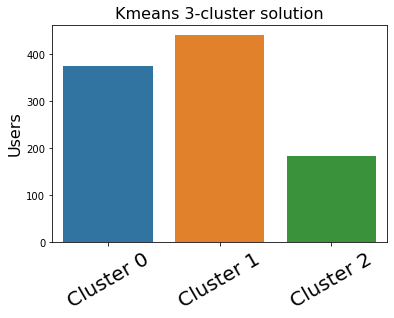

In [58]:
# OVERVIEW ON CLUSTERS
sns.countplot(data=users, x='kmeans_labels')
plt.title('Kmeans 3-cluster solution', fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('Users', fontsize=16)
plt.xticks(ticks=[0, 1, 2], labels=['Cluster 0', 'Cluster 1', 'Cluster 2'], fontsize=20, rotation=30)
plt.show()

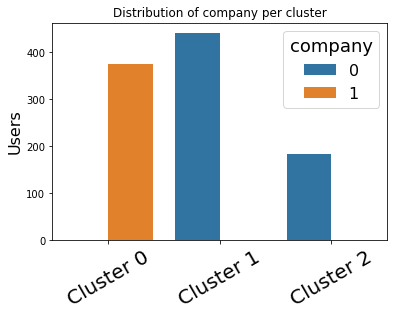

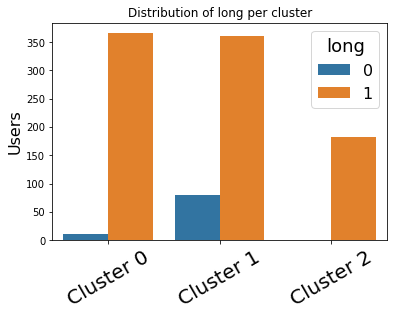

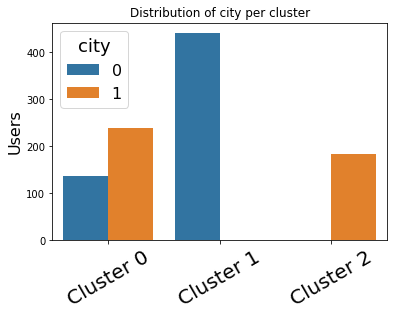

In [62]:

# VARIABLE PER CLUSTER
for col in users_clust:
    plt.title('Distribution of ' + str(col) + ' per cluster')
    fig = sns.countplot(data=users, x='kmeans_labels', hue=col)
    plt.xlabel('', fontsize=16)
    plt.ylabel('Users', fontsize=16)
    plt.xticks(ticks=[0, 1, 2], labels=['Cluster 0', 'Cluster 1', 'Cluster 2'], fontsize=20, rotation=30)
    legend = fig.legend(title=str(col), fontsize=16, loc='best')
    legend.get_title().set_fontsize('18')
    plt.show()

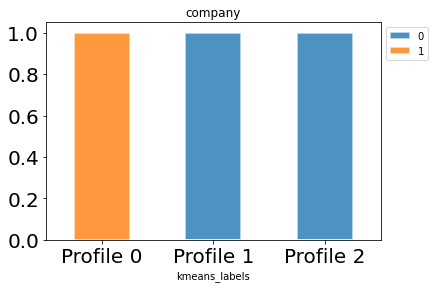

<Figure size 432x288 with 0 Axes>

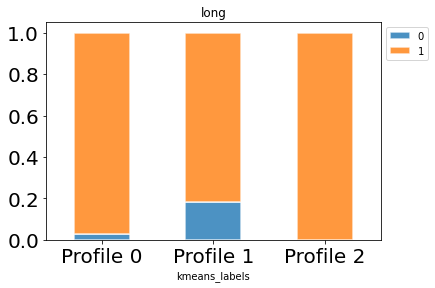

<Figure size 432x288 with 0 Axes>

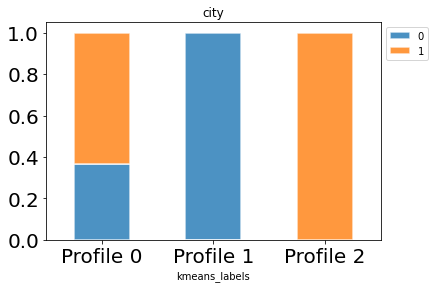

<Figure size 432x288 with 0 Axes>

In [63]:
for col in users_clust:
    bar_pl = users[col].groupby(users['kmeans_labels']).value_counts(normalize=True).unstack(1)
    bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title=col)
    plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
    plt.yticks(fontsize=20)
    plt.legend(bbox_to_anchor=(1,1))
    plt.figure()

plt.show()

In [64]:
colors = ['#32CD32', '#4169E1', '#FF69B4', '#FFA500', '#FFD700']
silhouette_scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k,
                max_iter=300,
                tol=1e-04,
                init='k-means++',
                n_init=10,
                random_state=42,
                algorithm='auto')
    km.fit(users_clust)
    silhouette_scores.append(silhouette_score(users_clust, km.labels_))

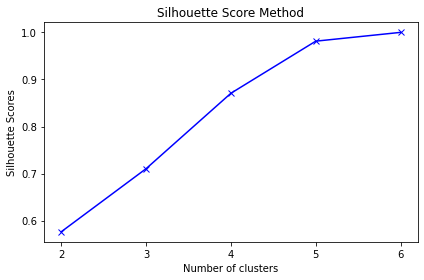

In [65]:
fig, ax = plt.subplots()
ax.plot(range(2, 7), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()